In [1]:
import torch 
# import sklearn

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from pandas import DataFrame

from tqdm import tqdm 
from data_utils import News20Data
# from transformers import BertModel, BertTokenizer
# from nltk.corpus import stopwords
from matplotlib.pyplot import figure
import matplotlib as mpl

In [2]:
from data_utils import News20Data

In [3]:
batch_size=20
dataset = News20Data(batch_size=batch_size)

Processing dataset ...
Reading data ...
... 0 seconds
Tokenizing and sorting train data ...
... 112 seconds
Tokenizing and sorting dev data ...
... 37 seconds
Tokenizing and sorting test data ...
... 37 seconds


In [4]:
def read_state_freq(path):
    state_freq = np.zeros(2000)
    state_nonstop_freq = np.zeros(2000)
    with open(path) as fd:
        lines = fd.readlines()
        for li, l in enumerate(lines):
            if(li % 3 == 0):
                l = l.split()
                state_id = int(l[1])
                state_freq[state_id] = int(l[3])
                state_nonstop_freq[state_id] = int(l[5])
    return state_freq, state_nonstop_freq

In [40]:
state_freq, state_nonstop_freq = read_state_freq('/home/s1946695/Scale-CRF-Latent-Space/outputs/bertnet_0.0.4.10.4/bertnet_dev_epoch_16_s2w.txt')

state_freq_norm = np.log(state_freq)
state_freq_norm = state_freq_norm - state_freq_norm.min()
state_freq_norm = state_freq_norm / state_freq_norm.max()

state_nonstop_freq_r = state_nonstop_freq / state_freq

state_idx_sort = state_freq.argsort()[::-1]
state_stop_freq = state_freq - state_nonstop_freq

# Zipf's Law of Words

## Preparations

In [53]:
def read_word_state_dist(fpath):
    word2state = dict()
    with open(fpath) as fd:
        lines = fd.readlines()
        for l in lines:
            if(l.startswith('word')):
                l_ = l.split()
                word = l_[1]
                freq = int(l_[3])
                if(freq > 0):
                    word2state[word] = {}
                    word2state[word]['freq'] = freq
            elif(l.startswith('s')):
                for sc in l[:-4].split(' | '):
                    sc = sc.split()
                    if(int(sc[1][1:]) > 0): word2state[word][int(sc[0][1:])] = int(sc[1][1:])
    return word2state

In [54]:
word2state = read_word_state_dist('/home/s1946695/Scale-CRF-Latent-Space/outputs/bertnet_0.0.4.10.4/bertnet_dev_epoch_16_w2s.txt')

## Overall

<BarContainer object of 30522 artists>

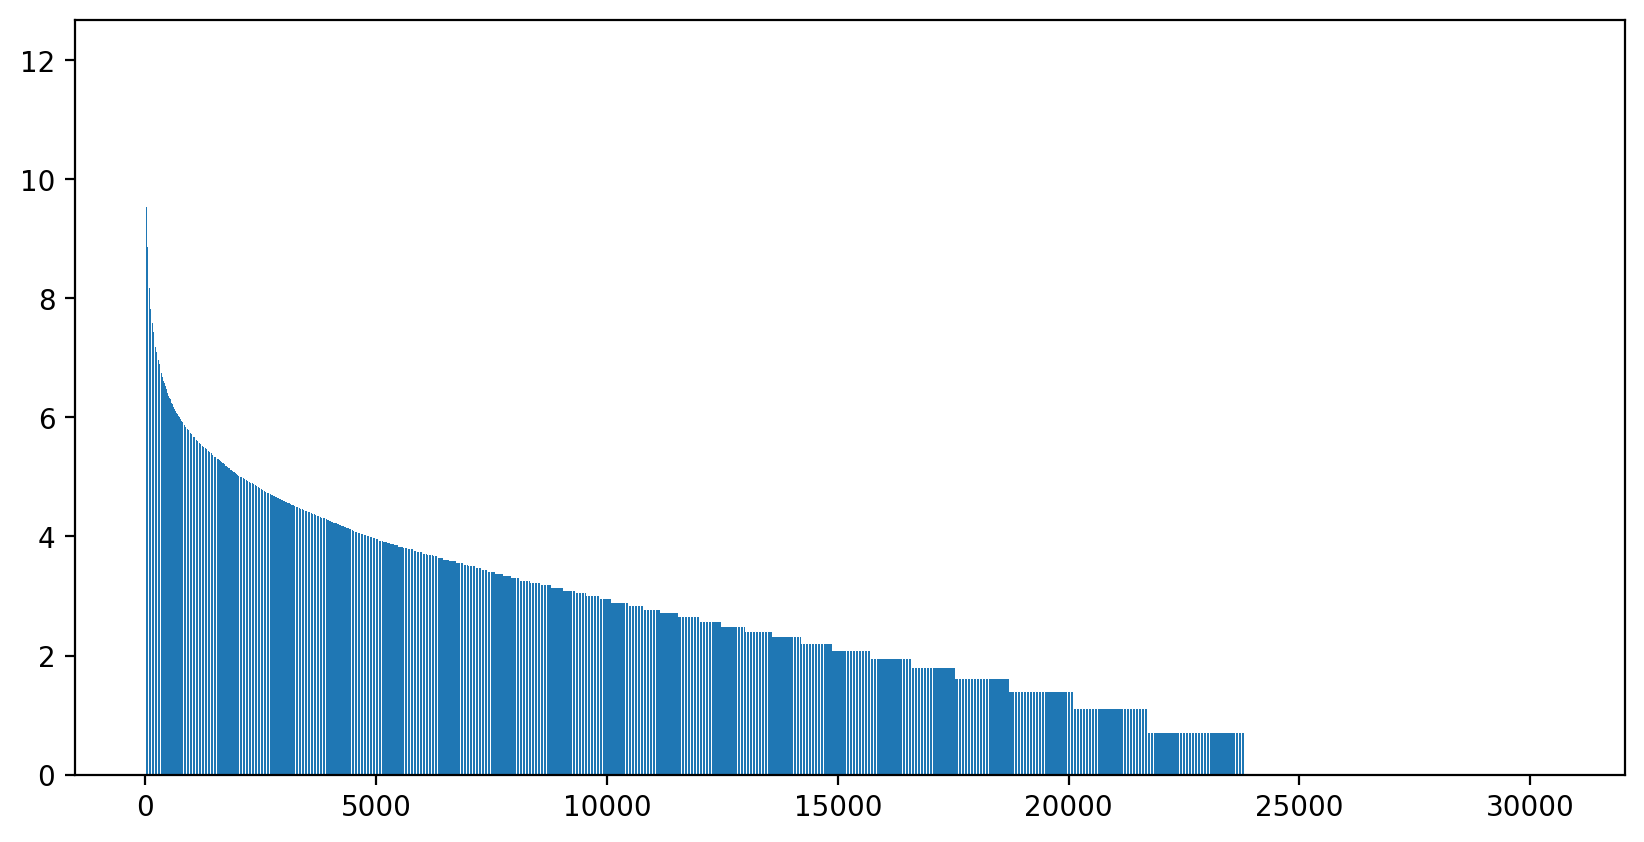

In [26]:
word_freq = np.array([word2state[w]['freq'] for w in word2state])

figure(figsize=(10, 5), dpi=200)
plt.bar(x=np.arange(len(word2state)), height=np.log(word_freq + 1))

## Colored by Number of State -- This figure clearly shows how high-frequent word takes more meaning

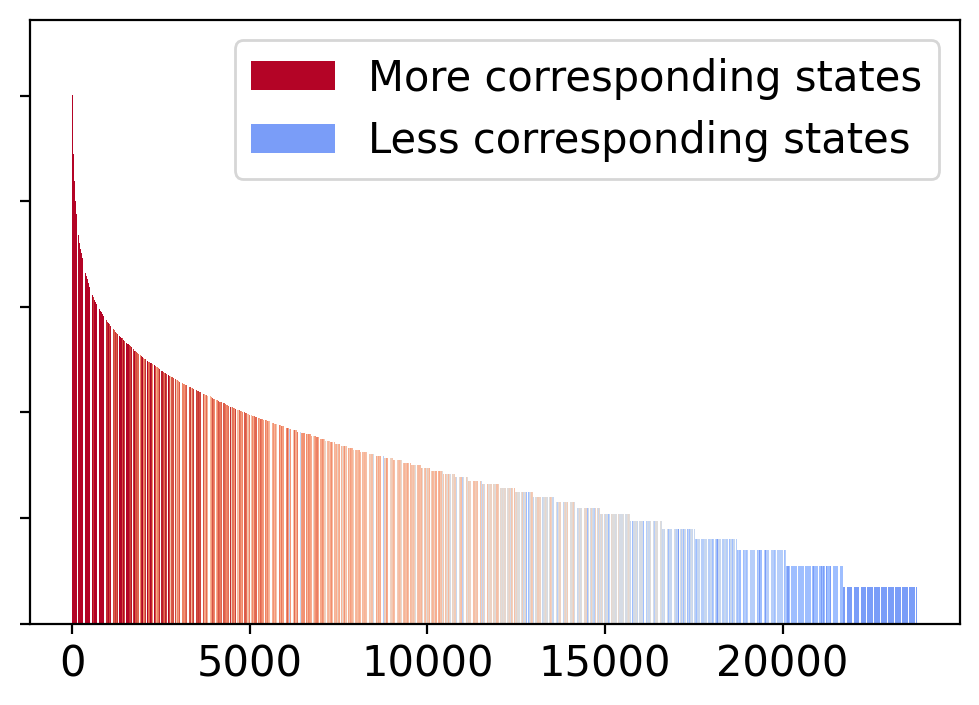

In [117]:
word_freq = np.array([word2state[w]['freq'] for w in word2state])
word_num_state = np.array([len(word2state[w]) for w in word2state])
word_num_state = np.log(word_num_state) + 0.1
word_num_state_norm = word_num_state / word_num_state.max()

figure(figsize=(6, 4), dpi=200)
cmap = mpl.cm.get_cmap('coolwarm')
word_freq_ = np.log(word_freq + 1)[3:]
plt.bar(x=np.arange(len(word_freq_)), height=word_freq_, color=cmap(word_num_state_norm))

fig_more_state = plt.bar(x=[0], height=[word_freq_[0]], color=cmap(word_num_state_norm)[0])
fig_less_state = plt.bar(x=[np.arange(len(word2state))[-1]], height=[word_freq_[-1]], color=cmap(word_num_state_norm)[-1])


plt.tick_params(axis='both', which='both', labelsize=15, labelleft=False, left=False) 
plt.legend((fig_more_state, fig_less_state), 
           ('More corresponding states', 'Less corresponding states'), 
           fontsize=15)

## Colored by Type of State

In [64]:
word_freq = np.log(np.array([word2state[w]['freq'] for w in word2state]) + 1)

word_state_type_top = []
word_state_type_rest = []
for w in word2state:
    topk_cnt = 0
    rest_cnt = 0
    for s in word2state[w]:
        if(isinstance(s, str)): pass
        elif(s in state_idx_sort[: 500]): topk_cnt += word2state[w][s]
        elif(s in state_idx_sort[500: ]): rest_cnt += word2state[w][s]
        else: print(s)
    word_state_type_top.append(topk_cnt)
    word_state_type_rest.append(rest_cnt)

word_state_type_top = np.array(word_state_type_top)
word_state_type_rest = np.array(word_state_type_rest)
word_state_type_full = np.array(word_state_type_top + word_state_type_rest)

word_state_type_top_ = word_freq * (word_state_type_top / (word_state_type_top + word_state_type_rest))
word_state_type_rest_ = word_freq * (word_state_type_rest / (word_state_type_top + word_state_type_rest))

# figure(figsize=(10, 5), dpi=200)
# plt.bar(x=np.arange(len(word2state)), height=np.log(word_freq + 1), color=cmap(word_num_state_norm))

In [93]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

### Most words are emitted by 

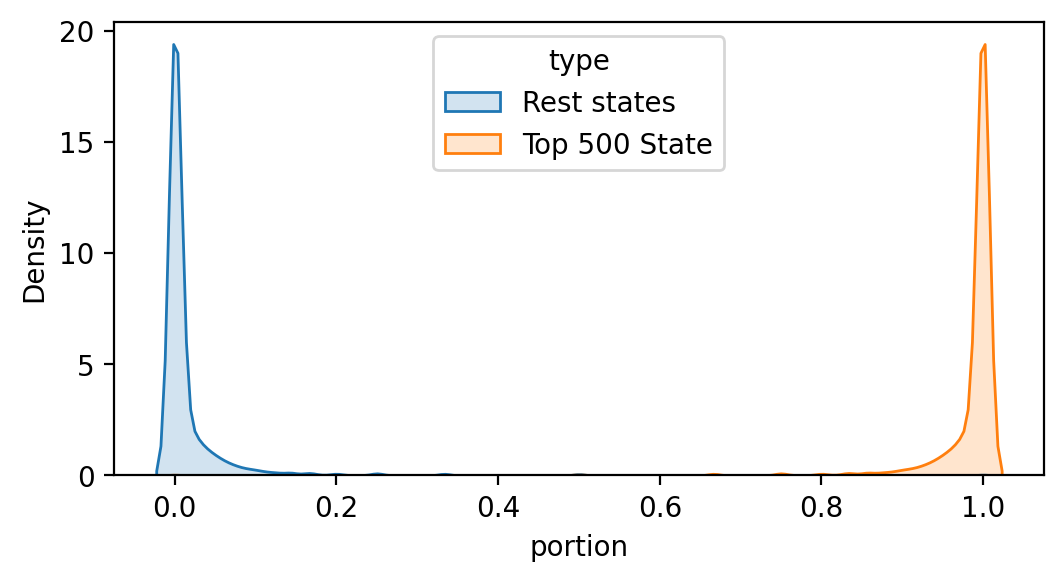

In [95]:
df = pd.DataFrame(
    {
     'portion': np.array(list(word_state_type_rest / word_state_type_full) + list(word_state_type_top / word_state_type_full)), 
     'type': ['Rest states'] * len(word_state_type_rest) + ['Top 500 State'] * len(word_state_type_full)
    }
    )

plt.figure(figsize=(6,3), dpi=200)
ax = sns.kdeplot(data=df, x="portion", fill=True, hue='type', alpha=.2,
#                 legend=False
               )
move_legend(ax, 'upper center')

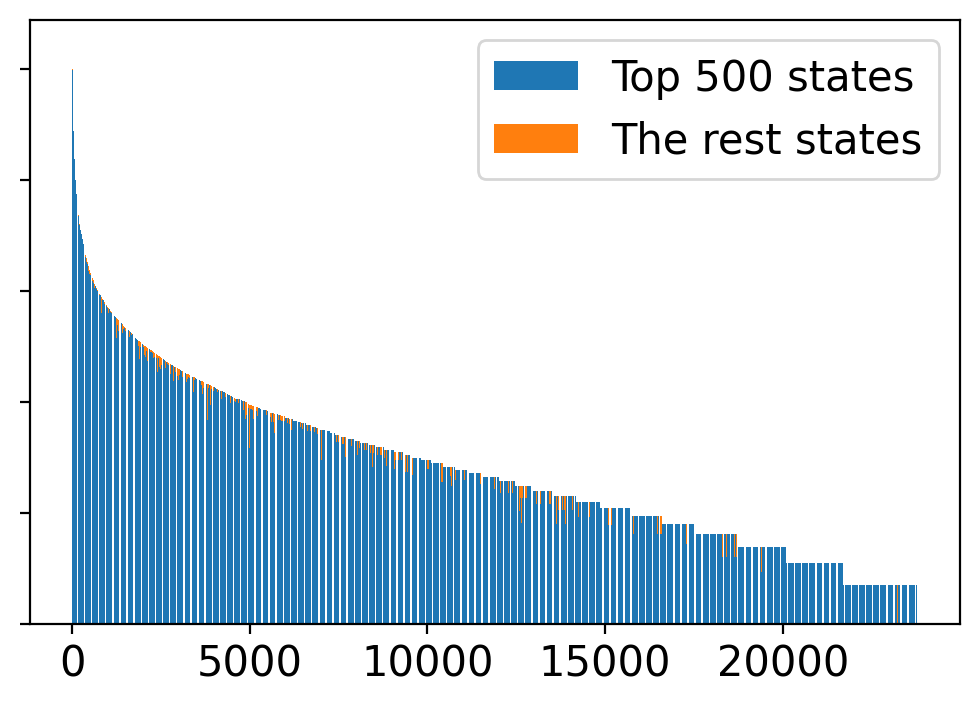

In [114]:
figure(figsize=(6, 4), dpi=200)
word_state_type_top_vis = word_state_type_top_[3::]
word_state_type_rest_vis = word_state_type_rest_[3::]
fig_top = plt.bar(x=np.arange(len(word_state_type_top_vis)), height=word_state_type_top_vis)
fig_rest = plt.bar(x=np.arange(len(word_state_type_top_vis)), height=word_state_type_rest_vis, bottom=word_state_type_top_vis)

plt.legend((fig_top, fig_rest), 
           ('Top 500 states', 'The rest states'), 
           fontsize=15)
# plt.ylim(10000)
plt.tick_params(axis='both', which='both', labelsize=15, labelleft=False, left=False) 

# Low frequency states v.s. low frequency words

# Zipf's Law of States

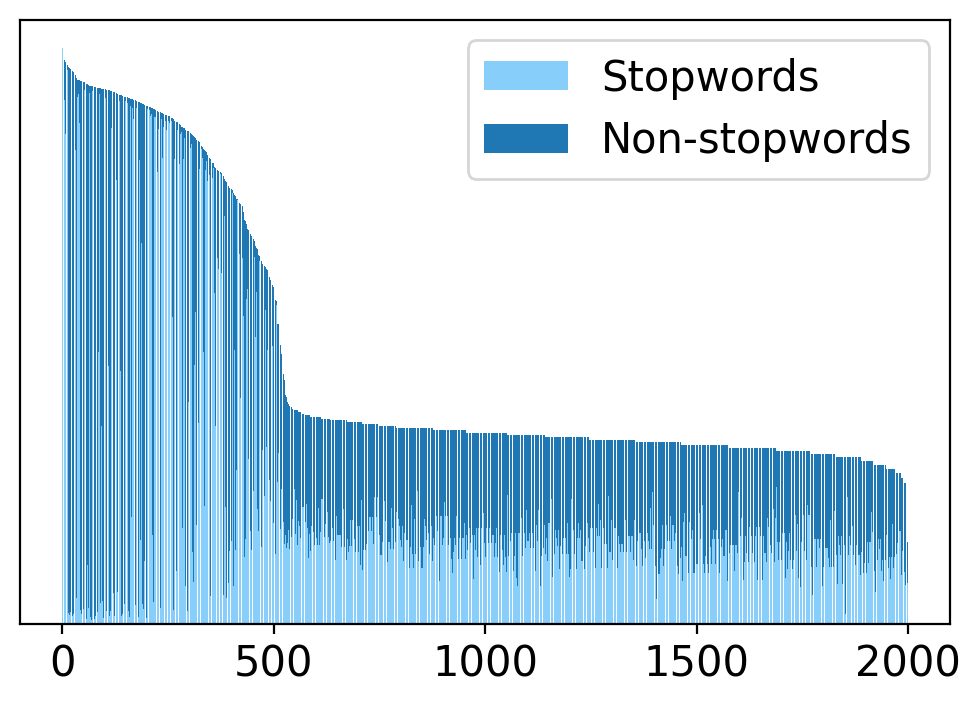

In [123]:
figure(figsize=(6, 4), dpi=200)
# fig, ax = plt.subplots()
state_freq_ = state_freq[idx_sort]
state_stop_freq_ = state_stop_freq[idx_sort]
state_nonstop_freq_ = state_nonstop_freq[idx_sort]

state_stop_freq_vis = np.log(state_freq_) * (state_stop_freq_ / state_freq_)
state_nonstop_freq_vis = np.log(state_freq_) * (state_nonstop_freq_ / state_freq_)

fig_stop = plt.bar(x=np.arange(2000), height=state_stop_freq_vis, color='lightskyblue')
fig_nonstop = plt.bar(x=np.arange(2000), height=state_nonstop_freq_vis, bottom=state_stop_freq_vis, color='tab:blue')

plt.legend((fig_stop, fig_nonstop), 
           ('Stopwords', 'Non-stopwords'), 
           fontsize=15)
# plt.yscale('log')
plt.tick_params(axis='both', which='both', left=False, labelsize=15, labelleft=False) 

/home/s1946695/miniconda3/envs/_dl_py36_dev/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


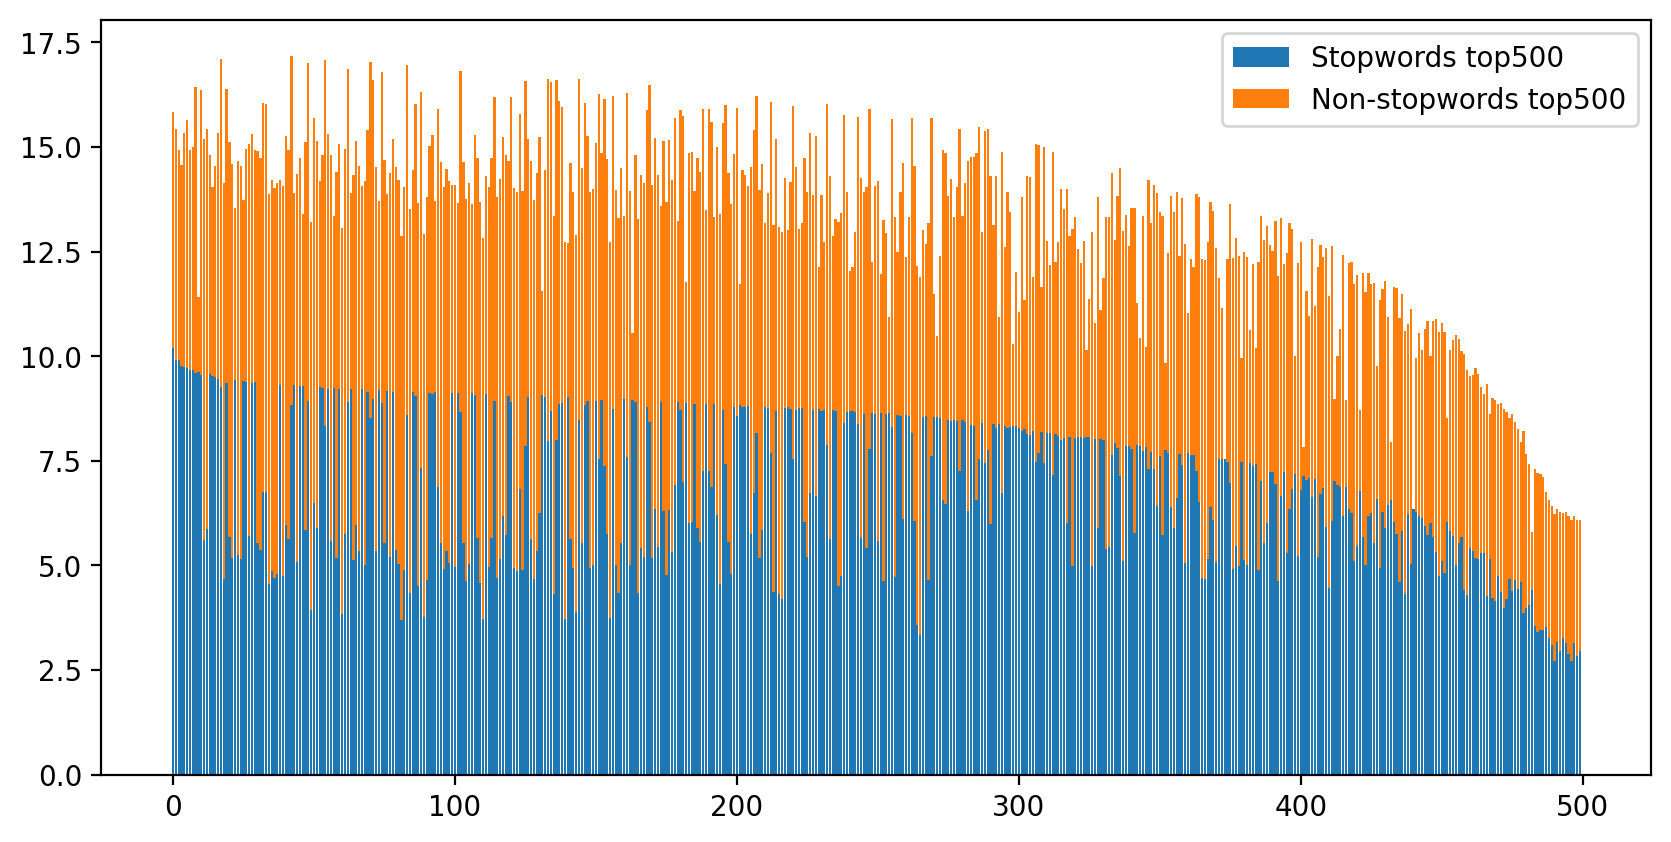

In [5]:
figure(figsize=(10, 5), dpi=200)
# fig, ax = plt.subplots()

fig_stop = plt.bar(x=np.arange(500), height=np.log(state_stop_freq[idx_sort])[:500])
fig_nonstop = plt.bar(x=np.arange(500), height=np.log(state_nonstop_freq[idx_sort])[:500], bottom=np.log(state_stop_freq[idx_sort])[:500])

plt.legend((fig_stop, fig_nonstop), 
           ('Stopwords top500', 'Non-stopwords top500'), 
           fontsize=10)

# Top freq. states are either static or dynamic. Less ferq. states are balanced

/home/s1946695/miniconda3/envs/_dl_py36_dev/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


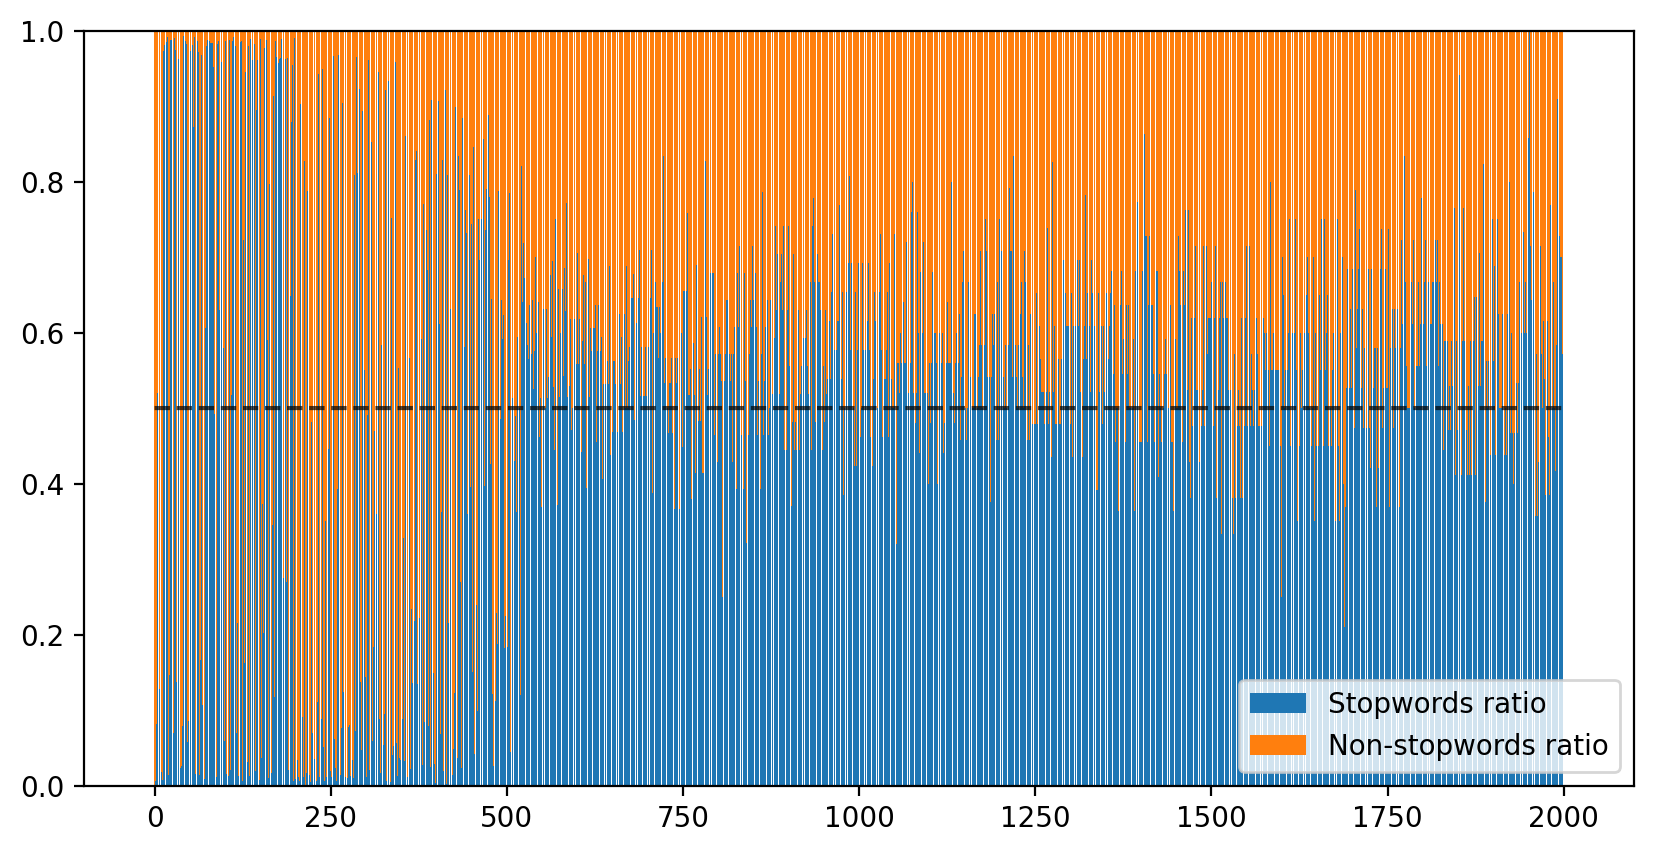

In [6]:
figure(figsize=(10, 5), dpi=200)

fig_stop = plt.bar(x=np.arange(2000), height=state_nonstop_freq_r[idx_sort], 
#                    color='#6BED42'
                  )
fig_nonstop = plt.bar(x=np.arange(2000), height=(1 - state_nonstop_freq_r[idx_sort]), bottom=state_nonstop_freq_r[idx_sort], 
#                       color='#EBF05B'
                     )
_ = plt.plot(np.arange(2000), [0.5] * 2000, '--', color='black', alpha=0.7)

plt.legend((fig_stop, fig_nonstop), 
           ('Stopwords ratio', 'Non-stopwords ratio'), 
           fontsize=10)

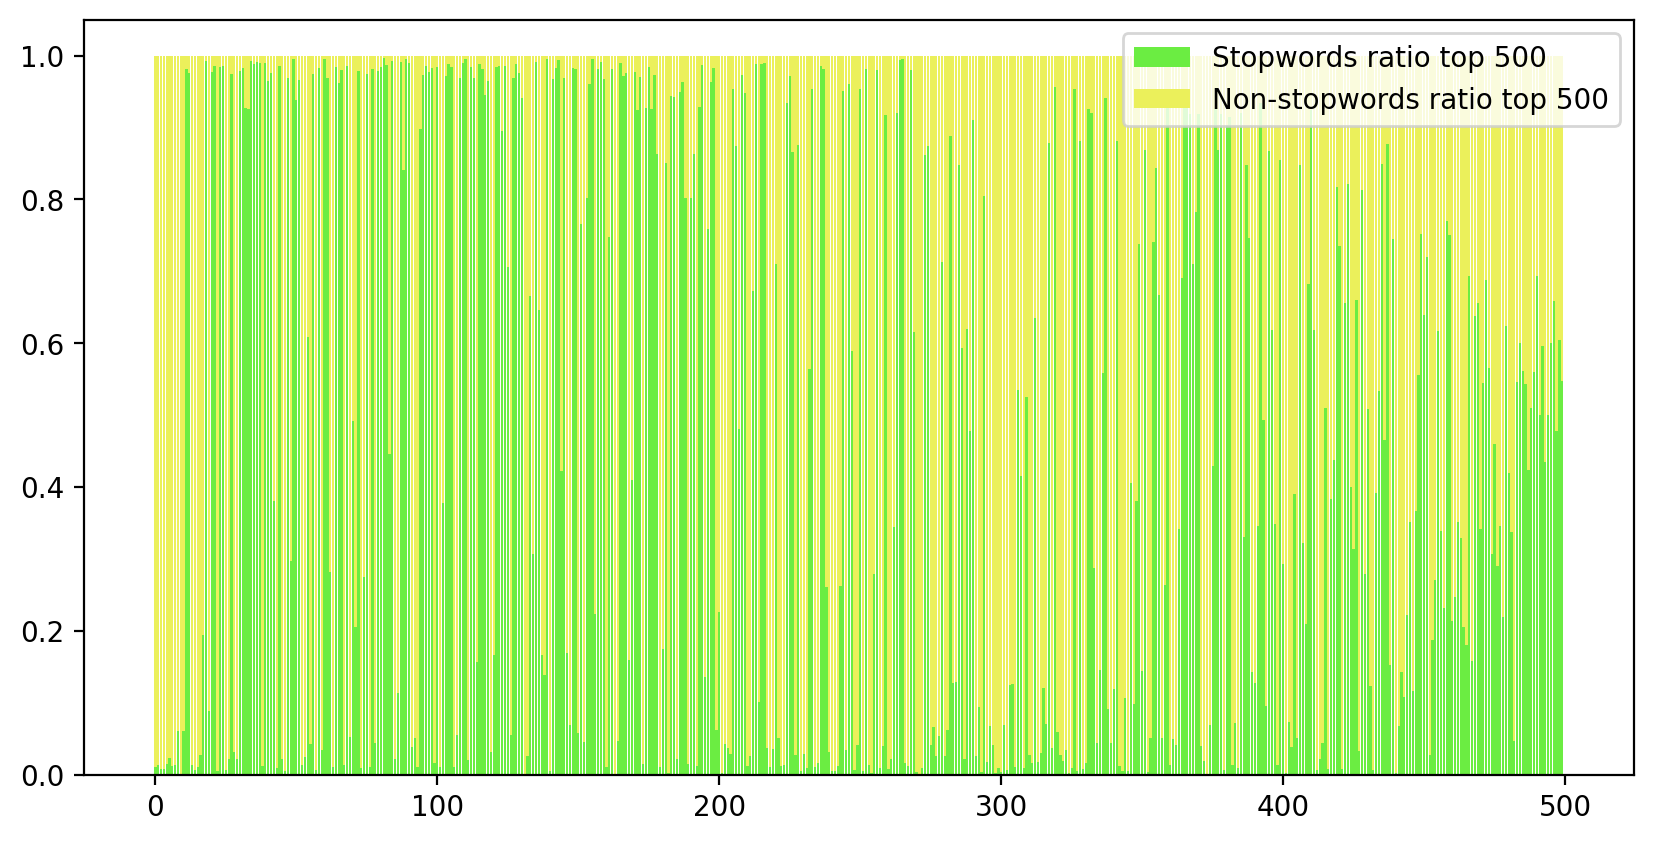

In [22]:
figure(figsize=(10, 5), dpi=200)

fig_stop = plt.bar(x=np.arange(500), height=state_nonstop_freq_r[idx_sort][:500], color='#6BED42')
fig_nonstop = plt.bar(x=np.arange(500), height=(1 - state_nonstop_freq_r[idx_sort])[:500], bottom=state_nonstop_freq_r[idx_sort][:500], color='#EBF05B')

plt.legend((fig_stop, fig_nonstop), 
           ('Stopwords ratio top 500', 'Non-stopwords ratio top 500'), 
           fontsize=10,
           loc='upper right'
          )

# State scale v.s. state frequence

In [6]:
ckpt_path = '../models/bertnet_0.0.4.10.3/e9-model.pt'
ckpt = torch.load(ckpt_path)
state_matrix = ckpt['state_matrix']

In [7]:
state_norm = (state_matrix ** 2).sum(-1).cpu().numpy()

In [21]:
idx_sort

array([1863, 1646,  509, ..., 1911, 1557,  297])

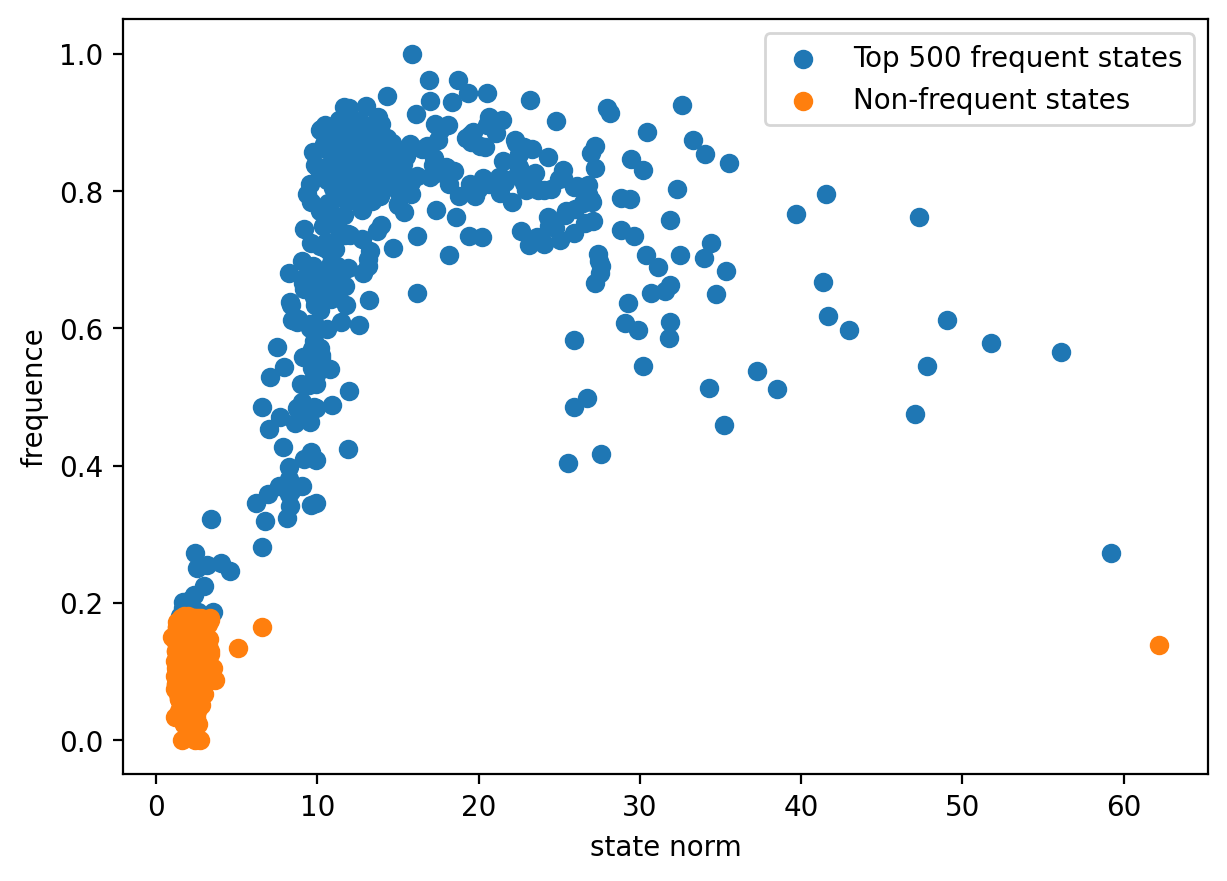

In [20]:
figure(figsize=(7, 5), dpi=200)

fig_freq = plt.scatter(x=state_norm[idx_sort][:500], y=state_freq_norm[idx_sort][:500], color='tab:blue')
fig_no_freq = plt.scatter(x=state_norm[idx_sort][500:], y=state_freq_norm[idx_sort][500:], color='tab:orange')
plt.xlabel('state norm')
plt.ylabel('frequence')

plt.legend((fig_freq, fig_no_freq), 
           ('Top 500 frequent states', 'Non-frequent states'), 
           fontsize=10,
           loc='upper right'
          )

In [27]:
state_dot_prod_mean = torch.matmul(state_matrix, state_matrix.transpose(0, 1)).mean(-1).cpu().numpy()

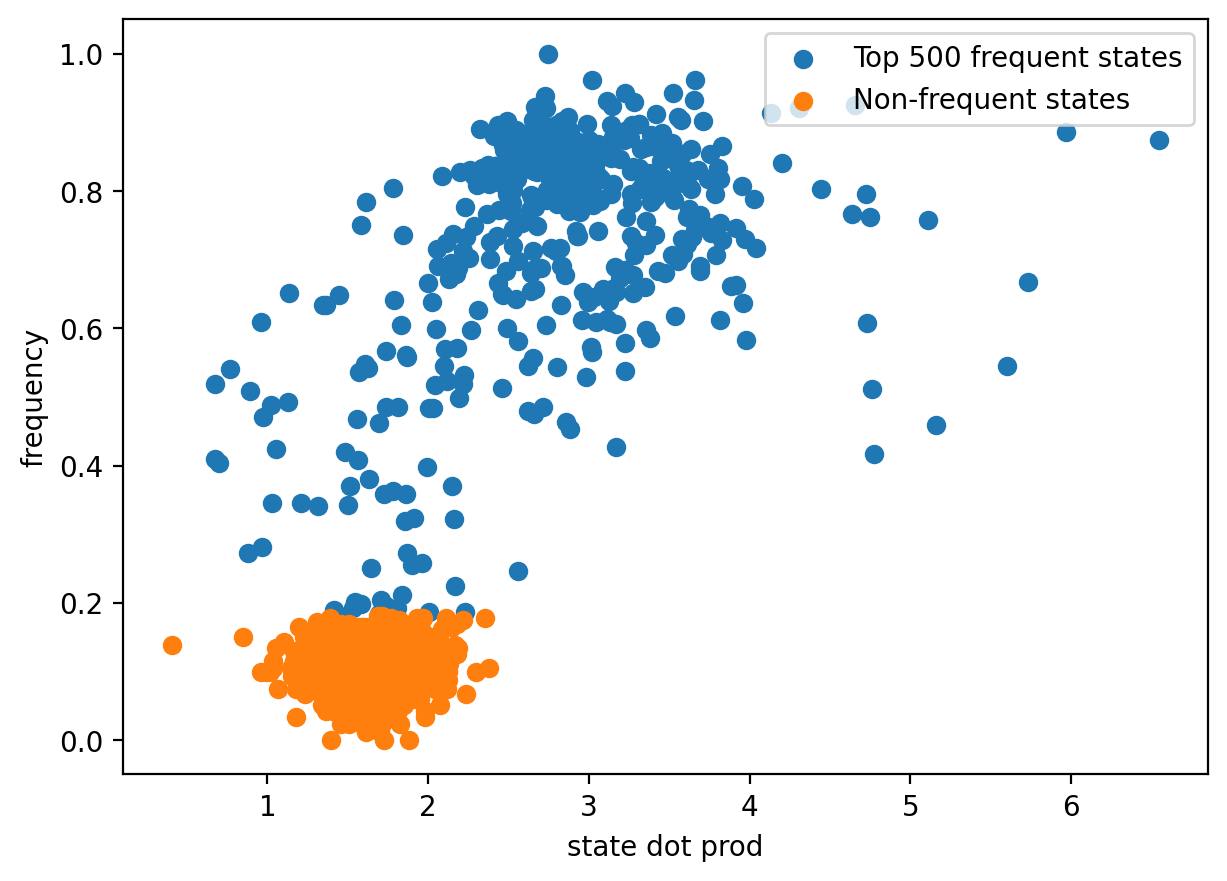

In [31]:
figure(figsize=(7, 5), dpi=200)

fig_freq = plt.scatter(x=state_dot_prod_mean[idx_sort][:500], y=state_freq_norm[idx_sort][:500], color='tab:blue')
fig_no_freq = plt.scatter(x=state_dot_prod_mean[idx_sort][500:], y=state_freq_norm[idx_sort][500:], color='tab:orange')
plt.xlabel('state dot prod')
plt.ylabel('frequency')

plt.legend((fig_freq, fig_no_freq), 
           ('Top 500 frequent states', 'Non-frequent states'), 
           fontsize=10,
           loc='upper right'
          )

## State freq v.s. dot prod

The more frequent a state is, the larger dot product it will have with other states

Text(0, 0.5, 'frequency')

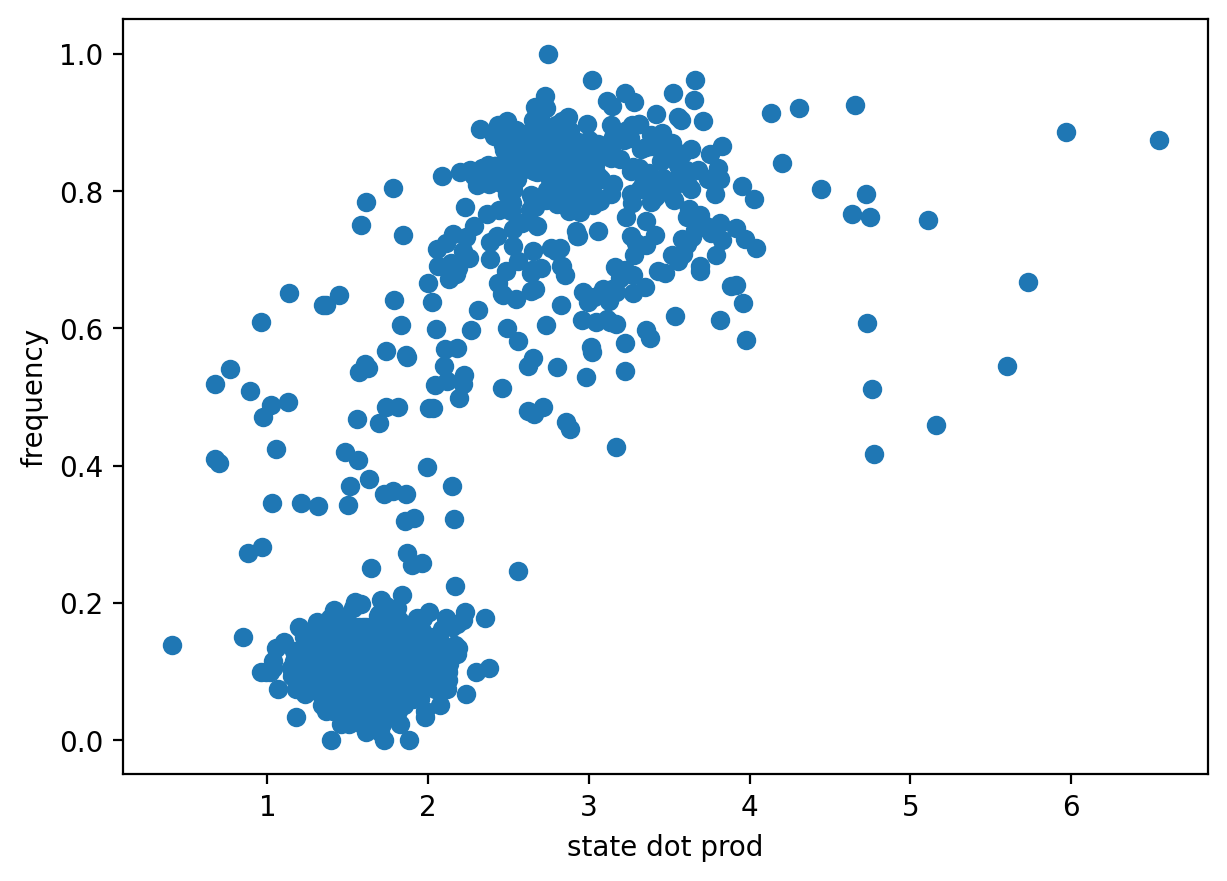

In [30]:
figure(figsize=(7, 5), dpi=200)

fig_freq = plt.scatter(x=state_dot_prod_mean, y=state_freq_norm, color='tab:blue')
plt.xlabel('state dot prod')
plt.ylabel('frequency')

# plt.legend((fig_freq, fig_no_freq), 
#            ('Top 500 frequent states', 'Non-frequent states'), 
#            fontsize=10,
#            loc='upper right'
#           )